In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from kneed import KneeLocator
from sklearn.manifold import TSNE
from scipy.stats import f_oneway
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings("ignore")

# Load datasets

In [105]:
tracks = pd.read_csv(r'fma_metadata/tracks.csv', index_col=0, header=[0, 1])
genres = pd.read_csv(r'fma_metadata/genres.csv')
echonest_data = pd.read_csv(r'fma_metadata/echonest.csv', index_col=0, header=[0, 1])

# Data Exploring and Preprocessing

In [106]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   (album, comments)            106574 non-null  int64  
 1   (album, date_created)        103045 non-null  object 
 2   (album, date_released)       70294 non-null   object 
 3   (album, engineer)            15295 non-null   object 
 4   (album, favorites)           106574 non-null  int64  
 5   (album, id)                  106574 non-null  int64  
 6   (album, information)         83149 non-null   object 
 7   (album, listens)             106574 non-null  int64  
 8   (album, producer)            18060 non-null   object 
 9   (album, tags)                106574 non-null  object 
 10  (album, title)               105549 non-null  object 
 11  (album, tracks)              106574 non-null  int64  
 12  (album, type)                100066 non-null  object 
 13 

In [107]:
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [108]:
tracks.drop_duplicates(inplace=True)

In [109]:
# Check for missing values
tracks.isna().sum()

album   comments                  0
        date_created           3529
        date_released         36280
        engineer              91279
        favorites                 0
        id                        0
        information           23425
        listens                   0
        producer              88514
        tags                      0
        title                  1025
        tracks                    0
        type                   6508
artist  active_year_begin     83863
        active_year_end      101199
        associated_labels     92303
        bio                   35418
        comments                  0
        date_created            856
        favorites                 0
        id                        0
        latitude              62030
        location              36364
        longitude             62030
        members               59725
        name                      0
        related_projects      93422
        tags                

In [110]:
# Check for blank values
sum(tracks[('track', 'genres_all')] == '[]')

2231

In [111]:
tracks = tracks[[('track', 'genre_top'), ('track', 'genres_all'),('track', 'title'), ('track', 'duration')]]

tracks.columns = tracks.columns.droplevel()
tracks.columns = ['genres_top', 'genres_all', 'track', 'duration']

In [112]:
print(genres.info())
genres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genre_id   163 non-null    int64 
 1   #tracks    163 non-null    int64 
 2   parent     163 non-null    int64 
 3   title      163 non-null    object
 4   top_level  163 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.5+ KB
None


,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [113]:
genres.drop_duplicates(inplace=True)         

In [114]:
genres.isna().sum()

genre_id     0
#tracks      0
parent       0
title        0
top_level    0
dtype: int64

In [115]:
print(echonest_data.info())
echonest_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 13131 entries, nan to 124911
Columns: 249 entries, ('echonest', 'audio_features') to ('echonest', 'temporal_features.223')
dtypes: float64(224), object(25)
memory usage: 25.0+ MB
None


echonest                                                      \
         audio_features audio_features.1 audio_features.2  audio_features.3   
NaN        acousticness     danceability           energy  instrumentalness   
track_id            NaN              NaN              NaN               NaN   
2          0.4166752327     0.6758939853     0.6344762684      0.0106280683   
3          0.3744077685     0.5286430621     0.8174611317      0.0018511032   
5          0.0435668989     0.7455658702     0.7014699916      0.0006967990   

                                                                              \
         audio_features.4 audio_features.5 audio_features.6 audio_features.7   
NaN              liveness      speechiness            tempo          valence   
track_id              NaN              NaN              NaN              NaN   
2            0.1776465712     0.1593100648   165.9220000000     0.5766609880   
3            0.1058799438     0.4618181276   126.9570000000     0.2692402421   
5            0.3731433124     0.1245953419   100.2600000000     0.6216612236   

                                  ...                        \
            metadata  metadata.1  ... temporal_features.214   
NaN       album_date  album_name  ...            214.000000   
track_id         NaN         NaN  ...                   NaN   
2                NaN         NaN  ...             -1.992303   
3                NaN         NaN  ...             -1.582331   
5                NaN         NaN  ...             -2.288358   

                                                                            \
         temporal_features.215 temporal_features.216 temporal_features.217   
NaN                 215.000000            216.000000            217.000000   
track_id                   NaN                   NaN                   NaN   
2                     6.805694              0.233070              0.192880   
3                     8.889308              0.258464              0.220905   
5                    11.527109              0.256821              0.237820   

                                                                            \
         temporal_features.218 temporal_features.219 temporal_features.220   
NaN                 218.000000             219.00000             220.00000   
track_id                   NaN                   NaN                   NaN   
2                     0.027455               0.06408               3.67696   
3                     0.081368               0.06413               6.08277   
5                     0.060122               0.06014               5.92649   

                                                                            
         temporal_features.221 temporal_features.222 temporal_features.223  
NaN                  221.00000            222.000000            223.000000  
track_id                   NaN                   NaN                   NaN  
2                      3.61288             13.316690            262.929749  
3                      6.01864             16.673548            325.581085  
5                      5.86635             16.013849            356.755737  

[5 rows x 249 columns]

In [116]:
echonest_data.drop_duplicates(inplace=True)

In [117]:
echonest_data.isna().sum()

echonest  audio_features           1
          audio_features.1         1
          audio_features.2         1
          audio_features.3         1
          audio_features.4         1
                                  ..
          temporal_features.219    1
          temporal_features.220    1
          temporal_features.221    1
          temporal_features.222    1
          temporal_features.223    1
Length: 249, dtype: int64

In [118]:
echonest_data = echonest_data[[('echonest','audio_features'), ('echonest','audio_features.1'), ('echonest','audio_features.2'), ('echonest','audio_features.3'), ('echonest','audio_features.4'), ('echonest','audio_features.5'), ('echonest','audio_features.6'), ('echonest','audio_features.7')]]
echonest_data.columns

echonest_data.columns = echonest_data.columns.droplevel() 
echonest_data.rename(columns=echonest_data.iloc[0], inplace=True)
echonest_data.drop(echonest_data.index[0], inplace=True)
echonest_data.drop(echonest_data.index[0], inplace=True)
echonest_data.index.name = 'track_id'

**Handling missing values**

In [119]:
tracks = tracks[tracks['genres_all'] != '[]']
tracks['genres_all'] = [map(int, i.strip('][').split(',')) for i in tracks['genres_all']]

In [120]:
genres_null = tracks.loc[(tracks['genres_top'].isnull()), ['genres_top', 'genres_all']].copy(deep=True)
genres_top = genres[genres.top_level == genres.genre_id]                 
genre_top_dict = dict(zip(genres_top.genre_id, genres_top.title))           
for index, row in genres_null.iterrows():                               
    for genre in row['genres_all']:
        if genre in genre_top_dict:
            tracks.loc[index, 'genres_top'] = genre_top_dict[genre]
            break

In [121]:
genres_all_dict = dict(zip(genres.genre_id, genres.title))
tracks['genres_all'] = [[genres_all_dict[j] for j in i] for i in tracks['genres_all']]

tracks.isna().sum()

genres_top    0
genres_all    0
track         1
duration      0
dtype: int64

**Misc**

In [122]:
tracks.drop('track', axis=1, inplace=True)
tracks[['genres_top']] = tracks[['genres_top']].astype('string')
tracks.dtypes

genres['title'] = genres['title'].astype('string')
genres.dtypes

echonest_data = echonest_data.apply(pd.to_numeric)

**Merge tracks metadata & audio features**

In [123]:
tracks = tracks.loc[tracks.index.isin(echonest_data.index.values)]
data_df = echonest_data.join(tracks, how='inner').reset_index(drop=True)             

In [124]:
data_df

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genres_top,genres_all,duration
0,0.947477,0.448822,0.120015,0.023712,0.149330,0.583456,78.235,0.626038,International,"[Europe, Jazz, Jazz: Vocal, Pop]",229
1,0.894214,0.936791,0.154907,0.304732,0.110080,0.545060,119.994,0.718722,International,"[Europe, Jazz, Jazz: Vocal, Pop]",238
2,0.990624,0.304892,0.101370,0.708325,0.115681,0.053470,89.416,0.493508,International,"[Europe, Jazz, Jazz: Vocal, Pop]",212
3,0.396601,0.502328,0.165570,0.002647,0.114401,0.873165,148.676,0.719476,International,"[Europe, Jazz, Jazz: Vocal, Pop]",197
4,0.903007,0.485873,0.074910,0.717737,0.080096,0.245856,146.322,0.581774,International,"[Europe, Jazz, Jazz: Vocal, Pop]",194
...,...,...,...,...,...,...,...,...,...,...,...
9030,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,Hip-Hop,"[Trip-Hop, Electronic]",268
9031,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,Hip-Hop,"[Trip-Hop, Electronic]",244
9032,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,Hip-Hop,"[Trip-Hop, Electronic]",382
9033,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,Hip-Hop,"[Trip-Hop, Electronic]",290


# Model

**Preparing features and gt**

In [125]:
only_features_df = data_df.drop(["genres_top", "genres_all",], axis=1)
external_vars_df = data_df[["genres_top", "genres_all"]]

scaler = StandardScaler()
normalized_features_df = (only_features_df-only_features_df.mean())/only_features_df.std()

**Choosing the best number of clusters**

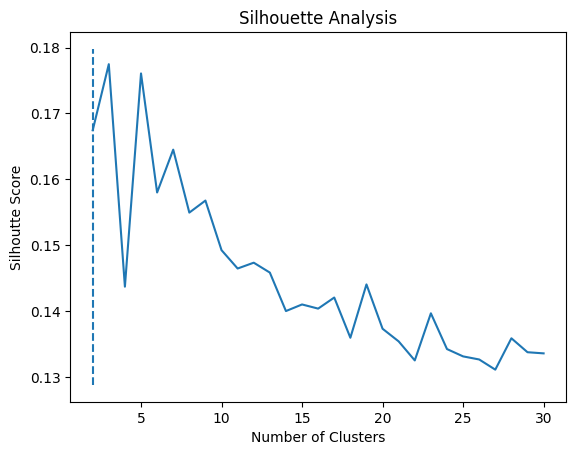

In [126]:
# silhouette analysis
s_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_features_df)
    s_scores.append(silhouette_score(normalized_features_df, kmeans.labels_))

plt.plot(range(2, 31), s_scores)

kn = KneeLocator(range(1, len(s_scores) + 1),
                 s_scores,
                 direction='increasing')

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.title('Silhouette Analysis')
plt.show()

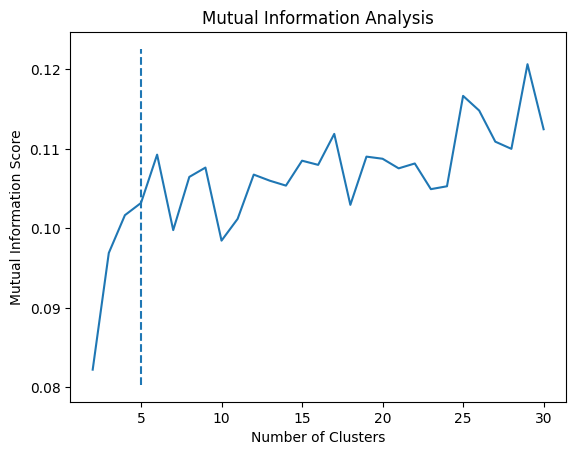

In [127]:
# mutual information analysis
s_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_features_df)
    s_scores.append(adjusted_mutual_info_score(external_vars_df["genres_top"], kmeans.labels_))

plt.plot(range(2, 31), s_scores)

kn = KneeLocator(range(1, len(s_scores) + 1),
                 s_scores,
                 direction='increasing')

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    
plt.xlabel("Number of Clusters")
plt.ylabel("Mutual Information Score")
plt.title('Mutual Information Analysis')
plt.show()

**We chose 5 clusters**

In [128]:
kmeans = KMeans(n_clusters=5).fit(normalized_features_df)
dbscan = DBSCAN().fit(normalized_features_df)
gmm = GMM(n_components=5).fit(normalized_features_df)
models = [kmeans, dbscan, gmm]
model_labels = [kmeans.labels_, dbscan.labels_, gmm.predict(normalized_features_df)]

In [129]:
mi_genre_kmeans = mutual_info_score(external_vars_df["genres_top"], model_labels[0])
mi_genre_dbscan = mutual_info_score(external_vars_df["genres_top"], model_labels[1])
mi_genre_gmm = mutual_info_score(external_vars_df["genres_top"], model_labels[2])

sil_genre_kmeans = silhouette_score(normalized_features_df, model_labels[0])
sil_genre_dbscan = silhouette_score(normalized_features_df, model_labels[1])
sil_genre_gmm = silhouette_score(normalized_features_df, model_labels[2])

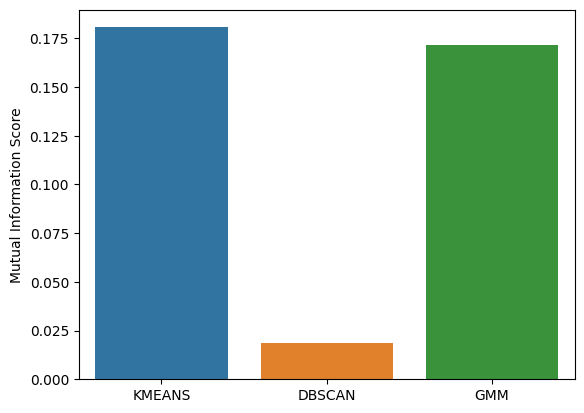

In [131]:
sns.barplot(x=["KMEANS", "DBSCAN", "GMM"], y=[mi_genre_kmeans, mi_genre_dbscan, mi_genre_gmm])
plt.ylabel("Mutual Information Score")
plt.show()

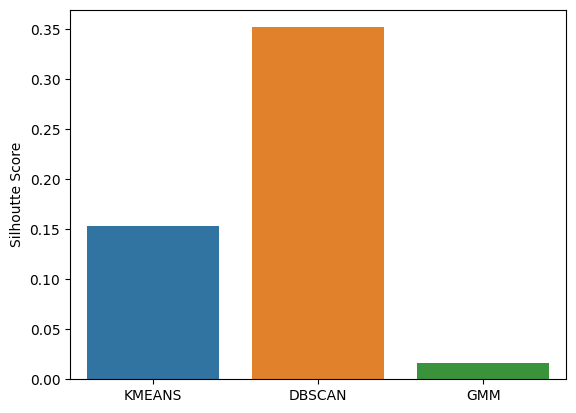

In [132]:
sns.barplot(x=["KMEANS", "DBSCAN", "GMM"], y=[abs(sil_genre_kmeans), abs(sil_genre_dbscan), abs(sil_genre_gmm)])
plt.ylabel("Silhoutte Score")
plt.show()

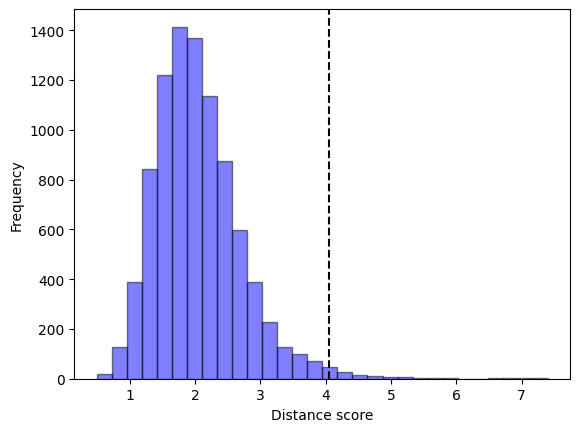

Threshold: 4.049555635171405
The anomalies percent for K-means is 1.1842833425567239%


In [133]:
km = KMeans()
km.fit(normalized_features_df)
scores = km.transform(normalized_features_df).min(axis=1)

plt.hist(scores, bins=30, color='b', alpha=0.5, edgecolor='black')

thresh = np.mean(scores) + 3 * np.std(scores)
plt.axvline(x=thresh, color='black', linestyle='--', linewidth=1.5)

plt.xlabel('Distance score')
plt.ylabel('Frequency')

plt.show()

print(f'Threshold: {thresh}')
print(f'The anomalies percent for K-means is {100 * len([i for i in scores if i > thresh]) / len(scores)}%')

Threshold: 1034.3548888078672
The anomalies percent for one class SVM is 12.097399003873823%


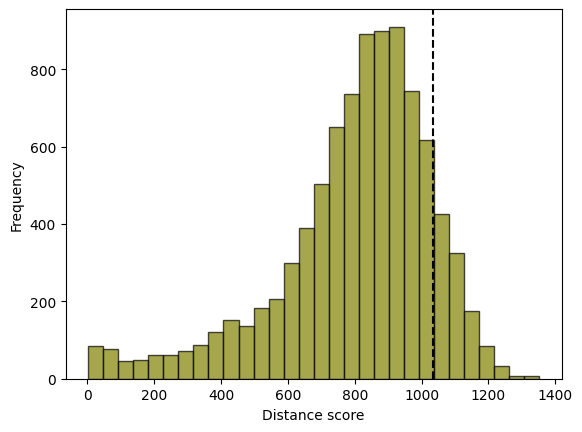

In [134]:
clf = OneClassSVM(gamma='auto')
clf.fit(normalized_features_df)
scores = clf.score_samples(normalized_features_df)

plt.hist(scores, bins=30, color='olive', alpha=0.7, edgecolor='black')

thresh = np.mean(scores) + 1 * np.std(scores)
plt.axvline(x=thresh, color='black', linestyle='--', linewidth=1.5)

print(f'Threshold: {thresh}')
print(f'The anomalies percent for one class SVM is {100 * len([i for i in scores if i > thresh]) / len(scores)}%')

plt.xlabel('Distance score')
plt.ylabel('Frequency')
plt.show()

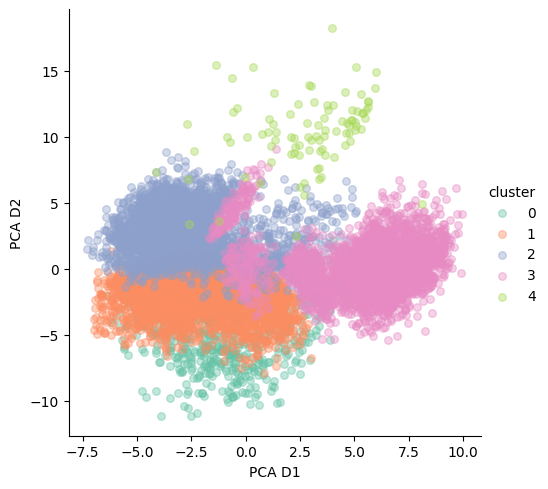

In [141]:
pca = PCA(n_components=2)           
reduced_features_df = pca.fit_transform(normalized_features_df)
comp_x, comp_y = zip(*reduced_features_df)
normalized_features_df['x'] = comp_x
normalized_features_df['y'] = comp_y
normalized_features_df['cluster'] = kmeans.labels_
sns.lmplot(data=normalized_features_df, x='x', y='y', hue='cluster', fit_reg=False, height=5, palette='Set2', scatter_kws={'alpha':0.4, 's':30})
plt.xlabel("PCA D1")
plt.ylabel("PCA D2")
plt.show()